In [56]:
import re
import pickle

# Load vocabulary dictionary containing 'word_to_idx'
with open("vocabulary.pkl", "rb") as f:
    vocab = pickle.load(f)
    word2idx = vocab['word_to_idx']  # Ensure you're accessing the correct dictionary

# Example text (single document with multiple sentences)
example = "Hello world! This is an example sentence. Another sentence follows."

# 1. Split into sentences
sentences = re.split(r'[.!?]', example)
sentences = [s.strip() for s in sentences if s.strip()]  # Remove empty strings and strip whitespace

# 2. Tokenize into words
tokenized = [s.split() for s in sentences]

# 3. Convert words to indices
numericalized = [
    [word2idx.get(w.lower(), word2idx.get("<UNK>", 0)) for w in sent]
    for sent in tokenized
]

# Output
print("Tokenized:", tokenized)
print("Numericalized:", numericalized)


Tokenized: [['Hello', 'world'], ['This', 'is', 'an', 'example', 'sentence'], ['Another', 'sentence', 'follows']]
Numericalized: [[11761, 179], [29, 14, 33, 1007, 1829], [206, 1829, 3400]]


Tokenized: [['Hello', 'world'], ['This', 'is', 'an', 'example', 'sentence'], ['Another', 'sentence', 'follows']]
Numericalized: [[11761, 179], [29, 14, 33, 1007, 1829], [206, 1829, 3400]]


In [ ]:
import pickle

with open("vocabulary.pkl", "rb") as f:
    vocab = pickle.load(f)

# print("Type of vocab:", type(vocab))
# print(dir(vocab))  # Show attributes/methods if it's a class or custom object
print(len(vocab))  # Length of vocab if it's a list or dict
for k, v in vocab.items():
    print(f"Key (repr): {repr(k)}, Value: lots of data")


word2idx = vocab['word_to_idx']  # Make sure this is a dict

i = 0
# Print all tokens
for token in word2idx.keys():
    print(token)
    i += 1
    if i > 10:  # Limit to first 10 tokens for brevity
        break
    


3
Key (repr): 'word_to_idx', Value: lots of data
Key (repr): 'idx_to_word', Value: lots of data
Key (repr): 'vocab_size', Value: lots of data
<PAD>
<UNK>
the
,
.
to
of
a
and
in
that


Tokenized: [['Hello', 'world'], ['This', 'is', 'an', 'example', 'sentence']]
Numericalized: [[11761, 179], [29, 14, 33, 1007, 1829]]


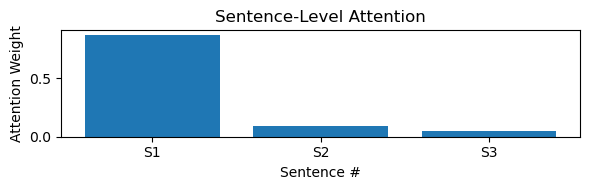

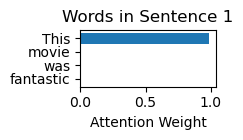

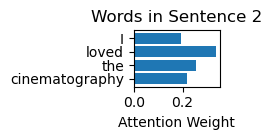

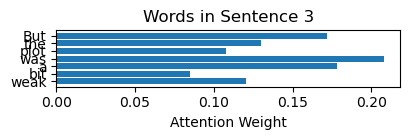

In [13]:
import torch
import matplotlib.pyplot as plt
from src.han_model import create_padding_for_hierarchical_sequences, HierarchicalAttentionNetwork
from sklearn.preprocessing._label import LabelEncoder

# Reconstruct the model and load weights (as previously done)
model = HierarchicalAttentionNetwork(
    vocabulary_size=50000,
    embedding_dimmentions=200,
    word_gru_hidden_units=50,
    word_gru_layers=1,
    word_attention_dimmentions=100,
    sentence_gru_hidden_units=50,
    sentence_gru_layers=1,
    sentence_attention_dimmention=100,
    number_of_classes=2
)
torch.serialization.add_safe_globals([LabelEncoder])
ckpt     = torch.load("best_han_model.pth", map_location="cpu", weights_only=False)
raw_sd   = ckpt["model_state_dict"]
fixed_sd = {}
for k, v in raw_sd.items():
    new_k = (
        k
        .replace("sentence_attention.sent_gru",            "sentence_attention.sentence_gru")
        .replace("sentence_attention.sent_attention",      "sentence_attention.sentence_attention")
        .replace("sentence_attention.sent_context_vector", "sentence_attention.sentence_context_vector")
    )
    fixed_sd[new_k] = v
model.load_state_dict(fixed_sd)
model.eval()

# Example text
example = [
    ["This", "movie", "was", "fantastic"],
    ["I", "loved", "the", "cinematography"],
    ["But", "the", "plot", "was", "a", "bit", "weak"]
]
word2idx = {
    "<PAD>": 0, "this":1, "movie":2, "was":3, "fantastic":4,
    "i":5, "loved":6, "the":7, "cinematography":8,
    "but":9, "plot":10, "a":11, "bit":12, "weak":13
}

# Numericalize
numericalized = [[word2idx.get(w.lower(), 0) for w in sent] for sent in example]

# Pad
docs, word_lens, sent_lens = create_padding_for_hierarchical_sequences([numericalized])
docs      = torch.LongTensor(docs)
word_lens = torch.LongTensor(word_lens)
sent_lens = torch.LongTensor(sent_lens)

# Forward pass
with torch.no_grad():
    logits, word_attn, sent_attn = model(docs, word_lens, sent_lens)

word_attn = word_attn.squeeze(0).cpu().numpy()
sent_attn = sent_attn.squeeze(0).cpu().numpy()

# Plot sentence attention
plt.figure(figsize=(6, 2))
plt.bar(range(len(example)), sent_attn)
plt.xlabel("Sentence #")
plt.ylabel("Attention Weight")
plt.title("Sentence-Level Attention")
plt.xticks(range(len(example)), [f"S{i+1}" for i in range(len(example))])
plt.tight_layout()
plt.show()

# Plot word attention for each sentence
for i, sent in enumerate(example):
    weights = word_attn[i, :len(sent)]
    plt.figure(figsize=(len(sent) * 0.6, 1.5))
    plt.barh(range(len(sent)), weights)
    plt.yticks(range(len(sent)), sent)
    plt.gca().invert_yaxis()
    plt.xlabel("Attention Weight")
    plt.title(f"Words in Sentence {i+1}")
    plt.tight_layout()
    plt.show()


In [16]:
import torch
import matplotlib.pyplot as plt
from nltk.tokenize import sent_tokenize, word_tokenize
from src.han_model import create_padding_for_hierarchical_sequences, HierarchicalAttentionNetwork
from sklearn.preprocessing._label import LabelEncoder
import nltk
nltk.download('punkt')

# Load the HAN model
model = HierarchicalAttentionNetwork(
    vocabulary_size=50000,
    embedding_dimmentions=200,
    word_gru_hidden_units=50,
    word_gru_layers=1,
    word_attention_dimmentions=100,
    sentence_gru_hidden_units=50,
    sentence_gru_layers=1,
    sentence_attention_dimmention=100,
    number_of_classes=2  # FAKE or REAL
)

# Fix deserialization for sklearn object
torch.serialization.add_safe_globals([LabelEncoder])

# Load and correct the model state dict
ckpt = torch.load("best_han_model.pth", map_location="cpu", weights_only=False)
raw_sd = ckpt["model_state_dict"]
fixed_sd = {}
for k, v in raw_sd.items():
    new_k = (
        k.replace("sentence_attention.sent_gru", "sentence_attention.sentence_gru")
         .replace("sentence_attention.sent_attention", "sentence_attention.sentence_attention")
         .replace("sentence_attention.sent_context_vector", "sentence_attention.sentence_context_vector")
    )
    fixed_sd[new_k] = v
model.load_state_dict(fixed_sd)
model.eval()

# Your word2idx mapping (needs to match your training vocab)
word2idx = {
    "<PAD>": 0, "this":1, "movie":2, "was":3, "fantastic":4,
    "i":5, "loved":6, "the":7, "cinematography":8,
    "but":9, "plot":10, "a":11, "bit":12, "weak":13,
    "president":14, "said":15, "economy":16, "is":17, "growing":18, "rapidly":19,
    "however":20, "multiple":21, "sources":22, "have":23, "disproved":24,
    "claims":25, "with":26, "actual":27, "data":28
    # Extend this dictionary as needed
}

def predict_and_visualize(text, model, word2idx):
    # Tokenize
    sentences = sent_tokenize(text)
    tokenized = [word_tokenize(s) for s in sentences]
    
    # Convert to indices
    numericalized = [[word2idx.get(w.lower(), 0) for w in sent] for sent in tokenized]

    # Prepare input tensors
    docs, word_lens, sent_lens = create_padding_for_hierarchical_sequences([numericalized])
    docs = torch.LongTensor(docs)
    word_lens = torch.LongTensor(word_lens)
    sent_lens = torch.LongTensor(sent_lens)

    # Predict
    with torch.no_grad():
        logits, word_attn, sent_attn = model(docs, word_lens, sent_lens)
    pred = torch.argmax(logits, dim=1).item()
    print("Prediction:", "FAKE" if pred == 1 else "REAL")

    # Sentence-level attention
    sent_attn = sent_attn.squeeze(0).cpu().numpy()
    plt.figure(figsize=(6, 2))
    plt.bar(range(len(tokenized)), sent_attn)
    plt.xlabel("Sentence #")
    plt.ylabel("Attention Weight")
    plt.title("Sentence-Level Attention")
    plt.xticks(range(len(tokenized)), [f"S{i+1}" for i in range(len(tokenized))])
    plt.tight_layout()
    plt.show()

    # Word-level attention
    word_attn = word_attn.squeeze(0).cpu().numpy()
    for i, sent in enumerate(tokenized):
        weights = word_attn[i, :len(sent)]
        plt.figure(figsize=(len(sent) * 0.6, 1.5))
        plt.barh(range(len(sent)), weights)
        plt.yticks(range(len(sent)), sent)
        plt.gca().invert_yaxis()
        plt.xlabel("Attention Weight")
        plt.title(f"Words in Sentence {i+1}")
        plt.tight_layout()
        plt.show()


# Example usage
if __name__ == "__main__":
    input_text = """
    The president said the economy is growing rapidly. 
    However, multiple sources have disproved the claims with actual data.
    """
    predict_and_visualize(input_text, model, word2idx)


[nltk_data] Downloading package punkt to /home/user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - '/home/user/nltk_data'
    - '/home/user/miniconda3/nltk_data'
    - '/home/user/miniconda3/share/nltk_data'
    - '/home/user/miniconda3/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


Prediction: REAL


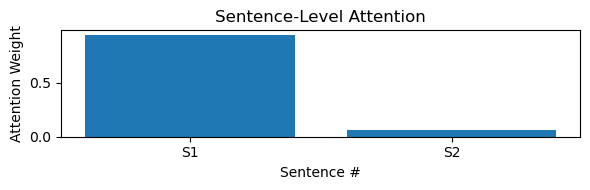

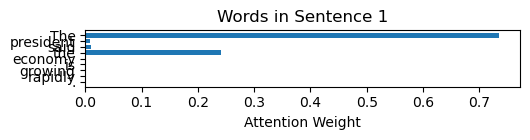

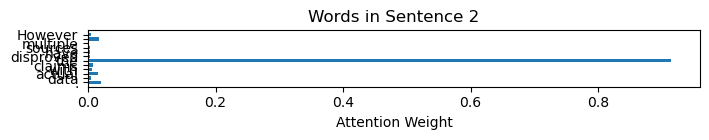

In [15]:
import re
import torch
import matplotlib.pyplot as plt
from src.han_model import (
    create_padding_for_hierarchical_sequences,
    HierarchicalAttentionNetwork,
)
from sklearn.preprocessing._label import LabelEncoder

# ----------------------------
# 1) Load your trained HAN
# ----------------------------
model = HierarchicalAttentionNetwork(
    vocabulary_size=50000,
    embedding_dimmentions=200,
    word_gru_hidden_units=50,
    word_gru_layers=1,
    word_attention_dimmentions=100,
    sentence_gru_hidden_units=50,
    sentence_gru_layers=1,
    sentence_attention_dimmention=100,
    number_of_classes=2,
)

torch.serialization.add_safe_globals([LabelEncoder])
ckpt = torch.load("best_han_model.pth", map_location="cpu", weights_only=False)
raw_sd = ckpt["model_state_dict"]
fixed_sd = {}
for k, v in raw_sd.items():
    new_k = (
        k.replace("sentence_attention.sent_gru", "sentence_attention.sentence_gru")
         .replace("sentence_attention.sent_attention", "sentence_attention.sentence_attention")
         .replace("sentence_attention.sent_context_vector", "sentence_attention.sentence_context_vector")
    )
    fixed_sd[new_k] = v
model.load_state_dict(fixed_sd)
model.eval()

# --------------------------------
# 2) Your word2idx mapping
#    (extend with your full vocab)
# --------------------------------
word2idx = {
    "<PAD>": 0, "the":1, "president":2, "said":3, "economy":4, "is":5, "growing":6,
    "rapidly":7, "however":8, "multiple":9, "sources":10, "have":11, "disproved":12,
    "claims":13, "with":14, "actual":15, "data":16,
    # … etc …
}

# ---------------------------------------------------------
# 3) A simple regex‐based tokenizer (no external downloads)
# ---------------------------------------------------------
def simple_tokenize(text: str):
    # Split into sentences on .!? + whitespace
    sentences = re.split(r'(?<=[\.!?])\s+', text.strip())
    # For each sentence, split into words/punctuation
    tokenized = [re.findall(r"\w+|[^\w\s]", sent) for sent in sentences]
    return sentences, tokenized

# -----------------------------------------------------
# 4) Predict + visualize function using that tokenizer
# -----------------------------------------------------
def predict_and_visualize(text, model, word2idx):
    # (a) Tokenize
    sentences, tokenized = simple_tokenize(text)

    # (b) Numericalize
    numericalized = [
        [word2idx.get(w.lower(), 0) for w in sent] for sent in tokenized
    ]

    # (c) Pad for HAN
    docs, word_lens, sent_lens = create_padding_for_hierarchical_sequences([numericalized])
    docs = torch.LongTensor(docs)
    word_lens = torch.LongTensor(word_lens)
    sent_lens = torch.LongTensor(sent_lens)

    # (d) Forward pass
    with torch.no_grad():
        logits, word_attn, sent_attn = model(docs, word_lens, sent_lens)

    pred = torch.argmax(logits, dim=1).item()
    label = "FAKE" if pred == 1 else "REAL"
    print(f"Prediction: {label}")

    # (e) Plot sentence‐level attention
    sent_weights = sent_attn.squeeze(0).cpu().numpy()
    plt.figure(figsize=(6, 2))
    plt.bar(range(len(sentences)), sent_weights)
    plt.xticks(range(len(sentences)), [f"S{i+1}" for i in range(len(sentences))])
    plt.xlabel("Sentence #")
    plt.ylabel("Attention Weight")
    plt.title("Sentence‐Level Attention")
    plt.tight_layout()
    plt.show()

    # (f) Plot word‐level attention
    word_weights = word_attn.squeeze(0).cpu().numpy()
    for i, sent in enumerate(tokenized):
        w = word_weights[i, : len(sent)]
        plt.figure(figsize=(len(sent) * 0.6, 1.5))
        plt.barh(range(len(sent)), w)
        plt.yticks(range(len(sent)), sent)
        plt.gca().invert_yaxis()
        plt.xlabel("Attention Weight")
        plt.title(f"Words in Sentence {i+1}")
        plt.tight_layout()
        plt.show()

# -----------------------
# 5) Example run
# -----------------------
if __name__ == "__main__":
    article = """
    The president said the economy is growing rapidly.
    However, multiple sources have disproved the claims with actual data.
    """
    predict_and_visualize(article, model, word2idx)


In [18]:
import re
import pickle
import torch
import matplotlib.pyplot as plt
import numpy as np
from src.han_model import HierarchicalAttentionNetwork, create_padding_for_hierarchical_sequences

# ----------------------------
# 1) Define TextPreprocessor
# ----------------------------
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from collections import Counter

class TextPreprocessor:
    """Text preprocessing utilities for hierarchical document structure."""

    def __init__(self, maximum_vocabulary_size=50000, minimum_word_frequency=2):
        self.maximum_vocabulary_size = maximum_vocabulary_size
        self.minimum_word_frequency = minimum_word_frequency
        self.word_to_idx = {}
        self.idx_to_word = {}
        self.vocabulary_size = 0

    def clean_text(self, text):
        """Clean and normalize text."""
        if pd.isna(text):
            return ""

        text = text.lower()
        text = re.sub(r"\s+", " ", text)
        text = re.sub(r"[^\w\s.,!?;:]", " ", text)
        return text.strip()

    def load_vocabulary(self, filepath):
        """Load vocabulary from file."""
        with open(filepath, "rb") as f:
            vocab_data = pickle.load(f)
        self.word_to_idx = vocab_data["word_to_idx"]
        self.idx_to_word = vocab_data["idx_to_word"]
        self.vocabulary_size = vocab_data["vocabulary_size"]

    def text_to_hierarchical_indices(
        self, text, max_sentences=20, max_words_per_sentence=50
    ):
        """Convert text to hierarchical structure of word indices."""
        cleaned_text = self.clean_text(text)
        sentences = sent_tokenize(cleaned_text)
        sentences = sentences[:max_sentences]

        hierarchical_doc = []
        for sent in sentences:
            words = word_tokenize(sent)
            words = words[:max_words_per_sentence]
            idxs = [self.word_to_idx.get(w, 1) for w in words]
            if idxs:
                hierarchical_doc.append(idxs)

        return hierarchical_doc if hierarchical_doc else [[1]]  # <UNK>

# ----------------------------------------------------
# 2) Load preprocessor vocabulary and initialize model
# ----------------------------------------------------

# Download punkt if needed
try:
    nltk.data.find("tokenizers/punkt")
except LookupError:
    nltk.download("punkt")

preprocessor = TextPreprocessor()
preprocessor.load_vocabulary("vocabulary.pkl")  # your saved vocab file

model = HierarchicalAttentionNetwork(
    vocabulary_size=preprocessor.vocabulary_size,
    embedding_dimmentions=200,
    word_gru_hidden_units=50,
    word_gru_layers=1,
    word_attention_dimmentions=100,
    sentence_gru_hidden_units=50,
    sentence_gru_layers=1,
    sentence_attention_dimmention=100,
    number_of_classes=2,
)

# Safe load
from sklearn.preprocessing._label import LabelEncoder
torch.serialization.add_safe_globals([LabelEncoder])
ckpt = torch.load("best_han_model.pth", map_location="cpu", weights_only=False)
raw_sd = ckpt["model_state_dict"]
fixed_sd = {}
for k, v in raw_sd.items():
    new_k = (
        k.replace("sentence_attention.sent_gru", "sentence_attention.sentence_gru")
         .replace("sentence_attention.sent_attention", "sentence_attention.sentence_attention")
         .replace("sentence_attention.sent_context_vector", "sentence_attention.sentence_context_vector")
    )
    fixed_sd[new_k] = v
model.load_state_dict(fixed_sd)
model.eval()

# ----------------------------------------------------
# 3) Prediction + Visualization Function
# ----------------------------------------------------

def predict_and_visualize_raw(text, model, preprocessor,
                               max_sentences=20, max_words=50):
    # Convert raw text
    hierarchical = preprocessor.text_to_hierarchical_indices(
        text, max_sentences, max_words
    )
    docs, word_lens, sent_lens = create_padding_for_hierarchical_sequences([hierarchical])
    docs = torch.LongTensor(docs)
    word_lens = torch.LongTensor(word_lens)
    sent_lens = torch.LongTensor(sent_lens)

    # Forward
    with torch.no_grad():
        logits, word_attn, sent_attn = model(docs, word_lens, sent_lens)
    pred = torch.argmax(logits, dim=1).item()
    print("Prediction:", "FAKE" if pred == 1 else "REAL")

    # Plot sentence attention
    sent_weights = sent_attn.squeeze(0).cpu().numpy()
    plt.figure(figsize=(6, 2))
    plt.bar(range(len(hierarchical)), sent_weights)
    plt.xlabel("Sentence #")
    plt.ylabel("Attention")
    plt.title("Sentence Attention")
    plt.xticks(range(len(hierarchical)), [f"S{i+1}" for i in range(len(hierarchical))])
    plt.tight_layout()
    plt.show()

    # Plot word attention
    word_weights = word_attn.squeeze(0).cpu().numpy()
    for i, sent in enumerate(hierarchical):
        tokens = [preprocessor.idx_to_word.get(idx, '<UNK>') for idx in sent]
        w = word_weights[i, :len(sent)]
        plt.figure(figsize=(len(sent)*0.6, 1.5))
        plt.barh(range(len(sent)), w)
        plt.yticks(range(len(sent)), tokens)
        plt.gca().invert_yaxis()
        plt.xlabel("Attention")
        plt.title(f"Words in Sent {i+1}")
        plt.tight_layout()
        plt.show()

# ---------------------------------------
# 4) Example Usage
# ---------------------------------------
if __name__ == "__main__":
    raw = (
        "The president said the economy is growing rapidly. "
        "However, multiple sources have disproved the claims with actual data."
    )
    predict_and_visualize_raw(raw, model, preprocessor)


KeyError: 'vocabulary_size'

In [19]:
import re
import pickle
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import argparse
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from src.han_model import HierarchicalAttentionNetwork, create_padding_for_hierarchical_sequences
from sklearn.preprocessing._label import LabelEncoder

# ----------------------------
# 1) TextPreprocessor
# ----------------------------
class TextPreprocessor:
    """Text preprocessing utilities for hierarchical document structure."""
    def __init__(self, vocab_path, max_vocab_size=50000, min_word_freq=2):
        self.vocab_path = vocab_path
        self.max_vocab_size = max_vocab_size
        self.min_word_freq = min_word_freq
        self.word_to_idx = {}
        self.idx_to_word = {}
        self.vocabulary_size = 0
        self._load_vocabulary()

    def _load_vocabulary(self):
        with open(self.vocab_path, "rb") as f:
            vocab_data = pickle.load(f)
        self.word_to_idx = vocab_data.get("word_to_idx", {})
        self.idx_to_word = vocab_data.get("idx_to_word", {})
        self.vocabulary_size = vocab_data.get("vocabulary_size", len(self.word_to_idx))

    def clean_text(self, text):
        if pd.isna(text): return ""
        text = text.lower()
        text = re.sub(r"\s+", " ", text)
        text = re.sub(r"[^\w\s.,!?;:]", " ", text)
        return text.strip()

    def text_to_hierarchical_indices(self, text, max_sents=20, max_words=50):
        sent_list = sent_tokenize(self.clean_text(text))[:max_sents]
        hierarchical = []
        for sent in sent_list:
            words = word_tokenize(sent)[:max_words]
            idxs = [self.word_to_idx.get(w, self.word_to_idx.get("<UNK>", 1)) for w in words]
            if idxs: hierarchical.append(idxs)
        return hierarchical if hierarchical else [[self.word_to_idx.get("<UNK>", 1)]]

# ----------------------------
# 2) Model Loader
# ----------------------------

def load_model(checkpoint_path, vocab_size):
    model = HierarchicalAttentionNetwork(
        vocabulary_size=vocab_size,
        embedding_dimmentions=200,
        word_gru_hidden_units=50,
        word_gru_layers=1,
        word_attention_dimmentions=100,
        sentence_gru_hidden_units=50,
        sentence_gru_layers=1,
        sentence_attention_dimmention=100,
        number_of_classes=2,
    )
    torch.serialization.add_safe_globals([LabelEncoder])
    ckpt = torch.load(checkpoint_path, map_location="cpu", weights_only=False)
    raw_sd = ckpt.get("model_state_dict", ckpt)
    fixed = {}
    for k, v in raw_sd.items():
        new_k = (k.replace("sentence_attention.sent_gru", "sentence_attention.sentence_gru")
                  .replace("sentence_attention.sent_attention", "sentence_attention.sentence_attention")
                  .replace("sentence_attention.sent_context_vector", "sentence_attention.sentence_context_vector"))
        fixed[new_k] = v
    model.load_state_dict(fixed)
    model.eval()
    return model

# ----------------------------
# 3) Prediction
# ----------------------------

def predict_attention(text, model, preprocessor, max_sents, max_words):
    hierarchical = preprocessor.text_to_hierarchical_indices(text, max_sents, max_words)
    docs, word_lens, sent_lens = create_padding_for_hierarchical_sequences([hierarchical])
    docs, word_lens, sent_lens = map(lambda x: torch.LongTensor(x), (docs, word_lens, sent_lens))
    with torch.no_grad():
        logits, w_att, s_att = model(docs, word_lens, sent_lens)
    pred = torch.argmax(logits, dim=1).item()
    return pred, w_att.squeeze(0).cpu().numpy(), s_att.squeeze(0).cpu().numpy(), hierarchical

# ----------------------------
# 4) Visualization
# ----------------------------

def visualize_attention(tokens_hier, w_att, s_att):
    # Sentence-level
    plt.figure(figsize=(6, 2))
    plt.bar(range(len(tokens_hier)), s_att)
    plt.xlabel("Sentence #")
    plt.ylabel("Attention Weight")
    plt.title("Sentence-Level Attention")
    plt.xticks(range(len(tokens_hier)), [f"S{i+1}" for i in range(len(tokens_hier))])
    plt.tight_layout()
    plt.show()

    # Word-level
    for i, sent in enumerate(tokens_hier):
        words = [preprocessor.idx_to_word.get(idx, '<UNK>') for idx in sent]
        weights = w_att[i, :len(words)]
        plt.figure(figsize=(len(words)*0.6, 1.5))
        plt.barh(range(len(words)), weights)
        plt.yticks(range(len(words)), words)
        plt.gca().invert_yaxis()
        plt.xlabel("Attention Weight")
        plt.title(f"Words in Sentence {i+1}")
        plt.tight_layout()
        plt.show()

# ----------------------------
# 5) Main: CLI
# ----------------------------

def main():
    parser = argparse.ArgumentParser(description="HAN Fake News Detection")
    parser.add_argument("--data", required=True, help="CSV file with raw text column")
    parser.add_argument("--text_col", default="text", help="Name of column with article text")
    parser.add_argument("--vocab", default="vocabulary.pkl", help="Path to vocab pickle")
    parser.add_argument("--model", default="best_han_model.pth", help="Path to model checkpoint")
    parser.add_argument("--max_sents", type=int, default=20)
    parser.add_argument("--max_words", type=int, default=50)
    parser.add_argument("--sample", type=int, default=None, help="Number of rows to process")
    args = parser.parse_args()

    # Ensure punkt tokenizer
    try:
        nltk.data.find("tokenizers/punkt")
    except LookupError:
        nltk.download("punkt")

    df = pd.read_csv(args.data)
    if args.sample:
        df = df.sample(args.sample, random_state=42).reset_index(drop=True)

    pre = TextPreprocessor(args.vocab)
    model = load_model(args.model, pre.vocabulary_size)

    results = []
    for idx, row in df.iterrows():
        text = row[args.text_col]
        pred, w_att, s_att, hier = predict_attention(
            text, model, pre, args.max_sents, args.max_words
        )
        results.append({
            "index": idx,
            "prediction": "FAKE" if pred==1 else "REAL",
            "sentence_attention": s_att.tolist(),
            "word_attention": [list(w) for w in w_att],
        })
        print(f"Row {idx}: {results[-1]['prediction']}")

    out_df = pd.DataFrame(results)
    out_csv = args.data.replace(".csv", "_predictions.csv")
    out_df.to_csv(out_csv, index=False)
    print(f"Saved predictions to {out_csv}")

if __name__ == "__main__":
    main()

usage: ipykernel_launcher.py [-h] --data DATA [--text_col TEXT_COL]
                             [--vocab VOCAB] [--model MODEL]
                             [--max_sents MAX_SENTS] [--max_words MAX_WORDS]
                             [--sample SAMPLE]
ipykernel_launcher.py: error: the following arguments are required: --data


SystemExit: 2

/home/user/miniconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [6]:
import torch
from src.han_model import HierarchicalAttentionNetwork, create_padding_for_hierarchical_sequences
from sklearn.preprocessing._label import LabelEncoder

# # 1. Reconstruct the model and load weights
# vocab_size            = 10000
# embedding_dim         = 200
# word_gru_hidden_units = 50
# word_gru_layers       = 1
# word_att_dim          = 100
# sent_gru_hidden_units = 50
# sent_gru_layers       = 1
# sent_att_dim          = 100
# n_classes             = 5


model = HierarchicalAttentionNetwork(
    vocabulary_size=50000,        # match checkpoint
    embedding_dimmentions=200,
    word_gru_hidden_units=50,
    word_gru_layers=1,
    word_attention_dimmentions=100,
    sentence_gru_hidden_units=50,
    sentence_gru_layers=1,
    sentence_attention_dimmention=100,
    number_of_classes=2           # match checkpoint
)

# 2. Allow unpickling of LabelEncoder so torch.load can succeed
torch.serialization.add_safe_globals([LabelEncoder])
# (Or, equivalently, use the context manager:
# with torch.serialization.safe_globals([LabelEncoder]):
#     checkpoint = torch.load(..., weights_only=False)
# )

# 3. Load the full checkpoint (weights_only=False) and grab only the model state
checkpoint = torch.load("best_han_model.pth", map_location="cpu", weights_only=False)
state_dict = checkpoint["model_state_dict"]

# 4. Feed it into your model
model.load_state_dict(state_dict)
model.eval()

RuntimeError: Error(s) in loading state_dict for HierarchicalAttentionNetwork:
	Missing key(s) in state_dict: "sentence_attention.sentence_gru.weight_ih_l0", "sentence_attention.sentence_gru.weight_hh_l0", "sentence_attention.sentence_gru.bias_ih_l0", "sentence_attention.sentence_gru.bias_hh_l0", "sentence_attention.sentence_gru.weight_ih_l0_reverse", "sentence_attention.sentence_gru.weight_hh_l0_reverse", "sentence_attention.sentence_gru.bias_ih_l0_reverse", "sentence_attention.sentence_gru.bias_hh_l0_reverse", "sentence_attention.sentence_attention.weight", "sentence_attention.sentence_attention.bias", "sentence_attention.sentence_context_vector.weight". 
	Unexpected key(s) in state_dict: "sentence_attention.sent_gru.weight_ih_l0", "sentence_attention.sent_gru.weight_hh_l0", "sentence_attention.sent_gru.bias_ih_l0", "sentence_attention.sent_gru.bias_hh_l0", "sentence_attention.sent_gru.weight_ih_l0_reverse", "sentence_attention.sent_gru.weight_hh_l0_reverse", "sentence_attention.sent_gru.bias_ih_l0_reverse", "sentence_attention.sent_gru.bias_hh_l0_reverse", "sentence_attention.sent_attention.weight", "sentence_attention.sent_attention.bias", "sentence_attention.sent_context_vector.weight". 

In [9]:
import torch
from src.han_model import HierarchicalAttentionNetwork

# 1. Instantiate with the *correct* vocab & class sizes
model = HierarchicalAttentionNetwork(
    vocabulary_size=50000,
    embedding_dimmentions=200,
    word_gru_hidden_units=50,
    word_gru_layers=1,
    word_attention_dimmentions=100,
    sentence_gru_hidden_units=50,
    sentence_gru_layers=1,
    sentence_attention_dimmention=100,
    number_of_classes=2
)

# 2. Load full checkpoint
checkpoint = torch.load("best_han_model.pth", map_location="cpu", weights_only=False)
raw_sd     = checkpoint["model_state_dict"]

# 3. Rename all "sent_*" prefixes → "sentence_*"
fixed_sd = {}
for key, tensor in raw_sd.items():
    new_key = (
        key
        .replace("sentence_attention.sent_gru",           "sentence_attention.sentence_gru")
        .replace("sentence_attention.sent_attention",     "sentence_attention.sentence_attention")
        .replace("sentence_attention.sent_context_vector","sentence_attention.sentence_context_vector")
    )
    fixed_sd[new_key] = tensor

# 4. Load into your model
model.load_state_dict(fixed_sd)
model.eval()


HierarchicalAttentionNetwork(
  (word_attention): WordAttention(
    (embedding): Embedding(50000, 200, padding_idx=0)
    (word_gru): GRU(200, 50, batch_first=True, bidirectional=True)
    (word_attention): Linear(in_features=100, out_features=100, bias=True)
    (word_context_vector): Linear(in_features=100, out_features=1, bias=False)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (sentence_attention): SentenceAttention(
    (sentence_gru): GRU(100, 50, batch_first=True, bidirectional=True)
    (sentence_attention): Linear(in_features=100, out_features=100, bias=True)
    (sentence_context_vector): Linear(in_features=100, out_features=1, bias=False)
    (classifier): Linear(in_features=100, out_features=2, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

In [10]:
import torch
from sklearn.preprocessing._label import LabelEncoder
from src.han_model  import HierarchicalAttentionNetwork

# 1) Reconstruct your model exactly as printed
model = HierarchicalAttentionNetwork(
    vocabulary_size=50000,              # 50k tokens
    embedding_dimmentions=200,          # 200-dim embeddings
    word_gru_hidden_units=50,
    word_gru_layers=1,
    word_attention_dimmentions=100,
    sentence_gru_hidden_units=50,
    sentence_gru_layers=1,
    sentence_attention_dimmention=100,
    number_of_classes=2                 # 2-way classifier
)

# 2) Allow LabelEncoder unpickling for full checkpoint load
torch.serialization.add_safe_globals([LabelEncoder])

# 3) Load checkpoint and extract its `model_state_dict`
ckpt     = torch.load("best_han_model.pth", map_location="cpu", weights_only=False)
raw_sd   = ckpt["model_state_dict"]

# 4) Rename prefixes so keys match your current class attributes
fixed_sd = {}
for k, v in raw_sd.items():
    new_k = (
        k
        .replace("sentence_attention.sent_gru",            "sentence_attention.sentence_gru")
        .replace("sentence_attention.sent_attention",      "sentence_attention.sentence_attention")
        .replace("sentence_attention.sent_context_vector", "sentence_attention.sentence_context_vector")
    )
    fixed_sd[new_k] = v

# 5) Load into your model and switch to eval mode
model.load_state_dict(fixed_sd)
model.eval()

# 6) Quick sanity check: forward on random input
batch_size          = 2
max_sents, max_words = 3, 5
dummy_docs = torch.randint(1, 50000, (batch_size, max_sents, max_words))
dummy_wlens = torch.randint(1, max_words+1, (batch_size, max_sents))
dummy_slens = torch.randint(1, max_sents+1, (batch_size,))

with torch.no_grad():
    logits, word_attn, sent_attn = model(dummy_docs, dummy_wlens, dummy_slens)
print("Logits shape:", logits.shape)            # → [2,2]
print("Word-attn shape:", word_attn.shape)      # → [2,3,5]
print("Sentence-attn shape:", sent_attn.shape)  # → [2,3]


Logits shape: torch.Size([2, 2])
Word-attn shape: torch.Size([2, 3, 5])
Sentence-attn shape: torch.Size([2, 3])


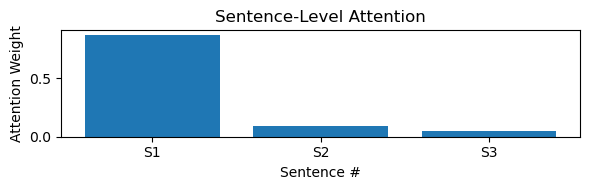

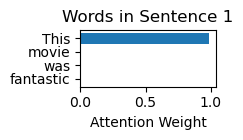

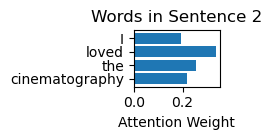

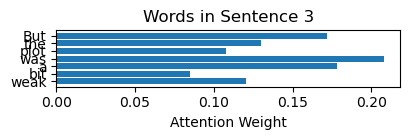

In [5]:
import torch

# 1. Pull out the raw state dict
checkpoint = torch.load("best_han_model.pth", map_location="cpu", weights_only=False)
sd        = checkpoint["model_state_dict"]

# 2. Build a new dict with corrected key names
renamed_sd = {}
for k, v in sd.items():
    # fix GRU prefix
    k = k.replace("sentence_attention.sent_gru",          "sentence_attention.sentence_gru")
    k = k.replace("sentence_attention.sent_attention",    "sentence_attention.sentence_attention")
    k = k.replace("sentence_attention.sent_context_vector","sentence_attention.sentence_context_vector")
    # (if there are others, chain more replace() calls here)
    renamed_sd[k] = v

# 3. Load into your freshly instantiated, hyperparameter-matched model
model.load_state_dict(renamed_sd)
model.eval()


RuntimeError: Error(s) in loading state_dict for HierarchicalAttentionNetwork:
	size mismatch for word_attention.embedding.weight: copying a param with shape torch.Size([50000, 200]) from checkpoint, the shape in current model is torch.Size([10000, 200]).
	size mismatch for sentence_attention.classifier.weight: copying a param with shape torch.Size([2, 100]) from checkpoint, the shape in current model is torch.Size([5, 100]).
	size mismatch for sentence_attention.classifier.bias: copying a param with shape torch.Size([2]) from checkpoint, the shape in current model is torch.Size([5]).

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np


# 2. Prepare your example text
example = [
    ["This", "movie", "was", "fantastic"],
    ["I", "loved", "the", "cinematography"],
    ["But", "the", "plot", "was", "a", "bit", "weak"]
]
# You need a word2idx mapping that matches your training
word2idx = {"<PAD>":0, "this":1, "movie":2, "was":3, "fantastic":4,
            "i":5, "loved":6, "the":7, "cinematography":8,
            "but":9, "plot":10, "a":11, "bit":12, "weak":13}
# Lowercase & map to indices (unk words → some idx, e.g. 0)
numericalized = [
    [word2idx.get(w.lower(), 0) for w in sent]
    for sent in example
]
# 3. Pad into tensors
docs, word_lens, sent_lens = create_padding_for_hierarchical_sequences([numericalized])
docs        = torch.LongTensor(docs).unsqueeze(0)        # [1, S, W]
word_lens   = torch.LongTensor(word_lens).unsqueeze(0)   # [1, S]
sent_lens   = torch.LongTensor(sent_lens)                # [1]

# 4. Forward pass & extract attentions
with torch.no_grad():
    logits, word_attn, sent_attn = model(docs, word_lens, sent_lens)
    # Shapes:
    #   sent_attn: [1, S]
    #   word_attn: [1, S, W]

sent_attn = sent_attn.squeeze(0).cpu().numpy()   # (num_sentences,)
word_attn = word_attn.squeeze(0).cpu().numpy()   # (num_sentences, max_word_len)

# === Visualization ===

# A) Sentence‐level: bar plot of how much each sentence contributes
plt.figure(figsize=(6,2))
plt.bar(range(len(example)), sent_attn)
plt.xlabel("Sentence #")
plt.ylabel("Sentence Attention")
plt.title("Sentence Attention Scores")
plt.xticks(range(len(example)), [f"S{i+1}" for i in range(len(example))])
plt.tight_layout()
plt.show()

# B) Word‐level: heatmaps per sentence
for i, sent in enumerate(example):
    weights = word_attn[i, :len(sent)]
    plt.figure(figsize=(len(sent)*0.6,1.5))
    plt.barh(range(len(sent)), weights)
    plt.yticks(range(len(sent)), sent)
    plt.gca().invert_yaxis()
    plt.xlabel("Word Attention")
    plt.title(f"Sentence {i+1}")
    plt.tight_layout()
    plt.show()


UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL sklearn.preprocessing._label.LabelEncoder was not an allowed global by default. Please use `torch.serialization.add_safe_globals([sklearn.preprocessing._label.LabelEncoder])` or the `torch.serialization.safe_globals([sklearn.preprocessing._label.LabelEncoder])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.